## Evaluation of XGB Experiments - Extract embeddings using fine-tuned DistilBERT

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c7324cd48bb21ba4936e0172ef55c966f1915e303033e080e7cfdfedb1ef2de7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
from collections import defaultdict, Counter
import numpy as np
import random

In [ ]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

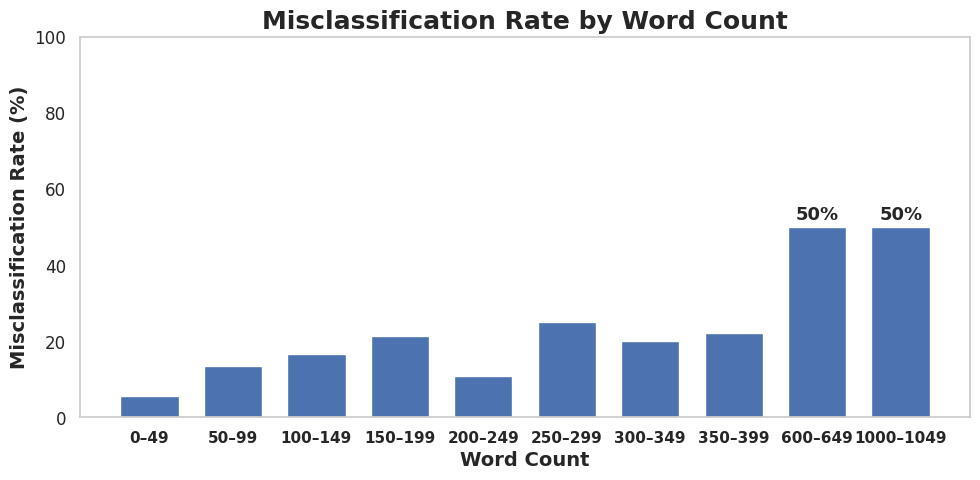

In [ ]:
df = pd.read_csv("XGB_distilbert_preds_experiment2.csv")

# Compute word count from the 'text' column
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['label'] = np.where(df['sentiment_id'] == df['FT_distilbert_pred'], 'correct', 'error')

# Binning by word count
bin_width = 50
bins = np.arange(0, df["word_count"].max() + bin_width, bin_width)
df["bin"] = pd.cut(df["word_count"], bins=bins, right=False)

# Compute error rate per bin
bin_counts = df.groupby(["bin", "label"], observed=True).size().unstack(fill_value=0)
bin_counts["total"] = bin_counts.sum(axis=1)
bin_counts["error_rate"] = (bin_counts.get("error", 0) / bin_counts["total"]) * 100
bin_counts = bin_counts[(bin_counts["total"] > 0) & (bin_counts["error_rate"] > 0)].reset_index()
bin_counts["bin_label"] = bin_counts["bin"].apply(lambda b: f"{int(b.left)}–{int(b.right) - 1}")

# Plot
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    bin_counts["bin_label"],
    bin_counts["error_rate"],
    color="#4C72B0",
    width=0.7
)

max_rate = bin_counts["error_rate"].max()
for bar, rate in zip(bars, bin_counts["error_rate"]):
    if rate == max_rate:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{int(rate)}%",
            ha='center',
            va='bottom',
            fontsize=13,
            weight='bold'
        )

ax.set_ylim(0, 100)
ax.set_title("Misclassification Rate by Word Count", fontsize=18, weight="bold")
ax.set_xlabel("Word Count", fontsize=14, weight="bold")
ax.set_ylabel("Misclassification Rate (%)", fontsize=14, weight="bold")
ax.set_xticks(range(len(bin_counts)))
ax.set_xticklabels(bin_counts["bin_label"], fontweight='bold', fontsize=11)
ax.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Check saved model and embeddings can be loaded and extracted

model_path = "distilbert_XGB_full_pipeline_experiment2.pkl"
embeddings_path = "X_test_embeds_distilbert_finetuned_experiment2.pkl"

class DistilBertVectorizer:
    def __init__(self, *args, **kwargs):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

# Load full pipeline
pipeline = joblib.load(model_path)
print("Full pipeline loaded.")

# Extract classifier from pipeline
clf = pipeline.named_steps['clf']
print("LogisticRegression model extracted.")

# Load test embeddings
X_test_embeds = joblib.load(embeddings_path)
print(f"Embeddings loaded. Shape: {X_test_embeds.shape}")

Full pipeline loaded.
LogisticRegression model extracted.
Embeddings loaded. Shape: (1000, 768)


## Plot Top words in Misclassified Reviews

In [ ]:
# Plot of misclassification

df = pd.read_csv("XGB_distilbert_preds_experiment2.csv")  # <- adjust if needed
df['embed_index'] = df.index
X_test_embeds = joblib.load("X_test_embeds_distilbert_finetuned_experiment2.pkl")

# Load classifier
class DistilBertVectorizer: pass
pipeline = joblib.load("distilbert_XGB_full_pipeline_experiment2.pkl")
clf = pipeline.named_steps['clf']
embed_lookup = dict(zip(df['text'], df['embed_index']))

# Filter misclassified samples
df['correct'] = df['sentiment_id'] == df['FT_distilbert_pred']
misclassified = df[df['correct'] == False].copy()

# Define prediction function using embeddings
def predict_proba(texts):
    indices = [embed_lookup.get(t, 0) for t in texts]
    return clf.predict_proba(X_test_embeds[indices])

# Function to group adjacent top words into phrases
def group_adjacent_phrases(text, top_words):
    tokens = text.split()
    phrases = []
    i = 0
    while i < len(tokens):
        if tokens[i] in top_words:
            phrase = [tokens[i]]
            i += 1
            while i < len(tokens) and tokens[i] in top_words:
                phrase.append(tokens[i])
                i += 1
            phrases.append(" ".join(phrase))
        else:
            i += 1
    return phrases

explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

lime_results = []
for i, row in tqdm(misclassified.iterrows(), total=len(misclassified)):
    text = row['text']
    true_label = row['sentiment_id']
    pred_label = row['FT_distilbert_pred']
    try:
        explanation = explainer.explain_instance(text, predict_proba, num_features=30)
        top_words = [word for word, _ in explanation.as_list()]
        grouped_phrases = group_adjacent_phrases(text, top_words)
        lime_results.append({
            'index': i,
            'text': text,
            'true_label': true_label,
            'pred_label': pred_label,
            'top_phrases': grouped_phrases
        })
    except Exception as e:
        print(f"Skipping index {i}: {e}")

lime_df = pd.DataFrame(lime_results)
lime_df['true_label_name'] = lime_df['true_label'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
lime_df['pred_label_name'] = lime_df['pred_label'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
print(lime_df[['index', 'true_label_name', 'pred_label_name', 'top_phrases']].head())

100%|██████████| 118/118 [01:11<00:00,  1.66it/s]

   index true_label_name pred_label_name  \
0     13         Neutral        Negative   
1     14        Negative         Neutral   
2     16        Positive        Negative   
3     36        Positive         Neutral   
4     50         Neutral        Negative   

                                         top_phrases  
0  [I found the food on SIA, class to and from Ho...  
1  [very, my flight, SQ 968, 06, my, After, arrou...  
2  [Booked to, to, to, to, Reap to, to, Followed,...  
3  [The flight, good there were no delays quick c...  
4  [expecting, good quality, was, aisles, very, v...  


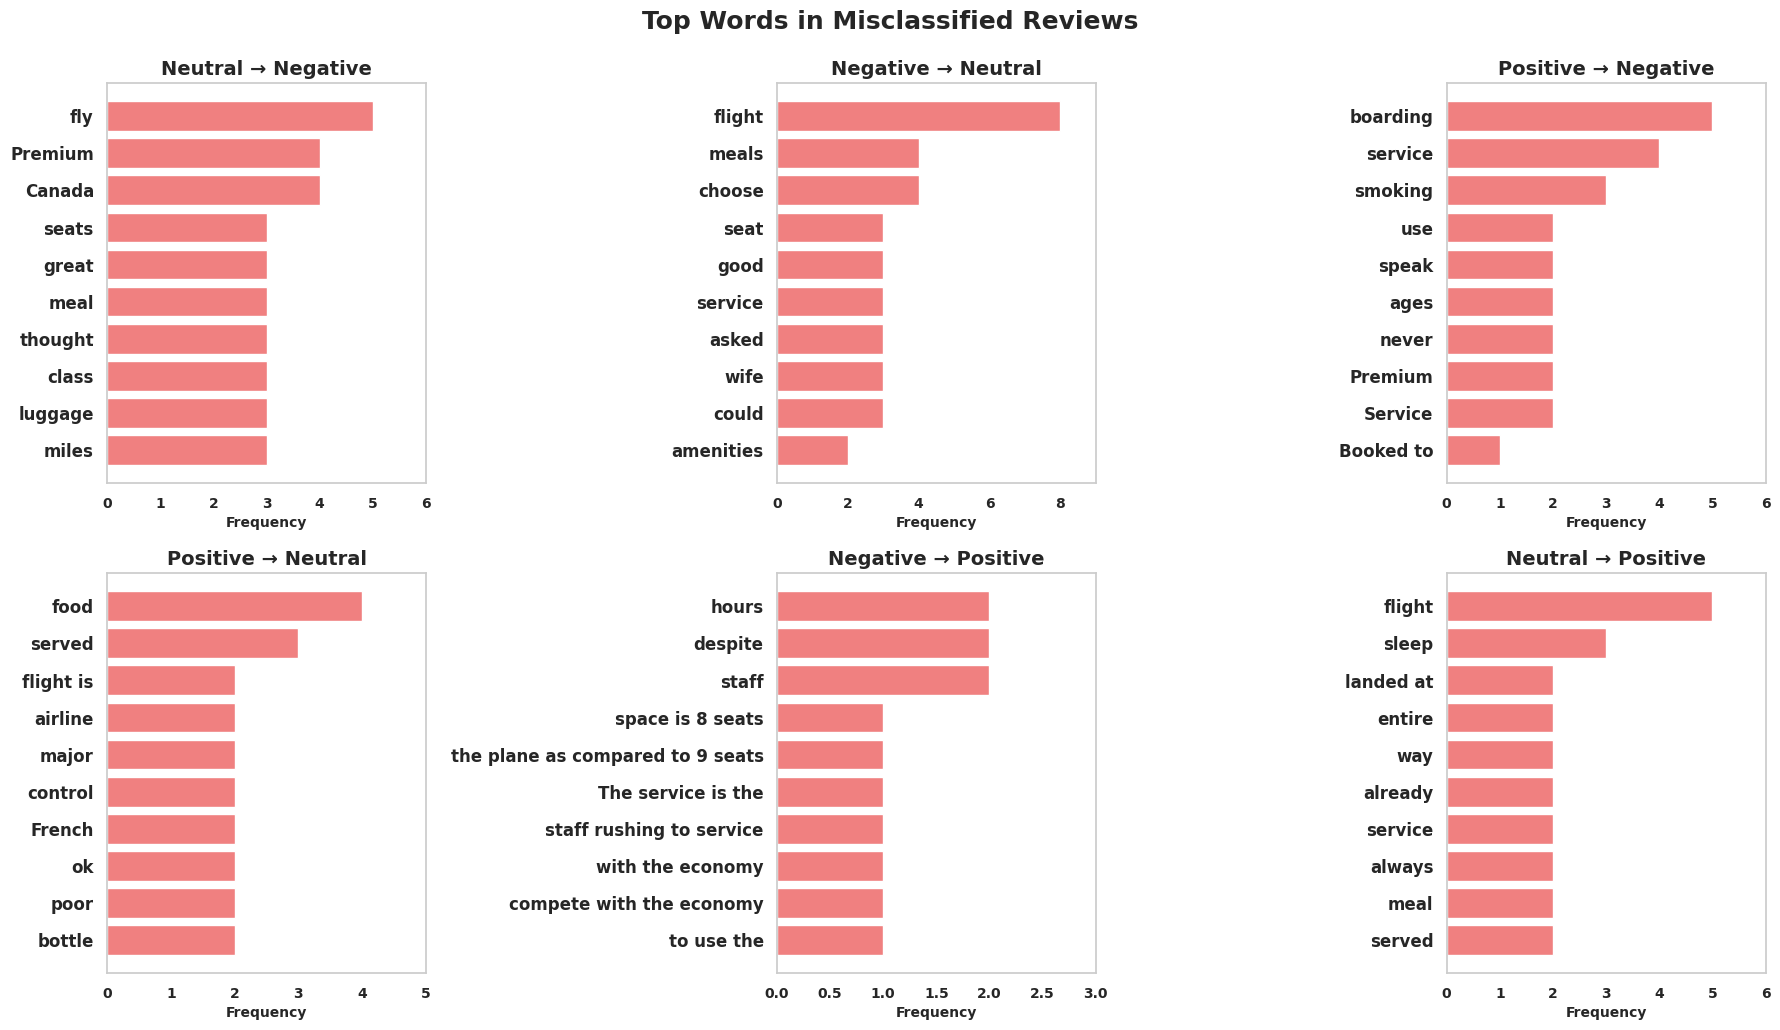

In [ ]:
# stopword list
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
    'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
    'should', 'now', 'would', 'told', 'go', 'got', 'get', 'singapore', 'airlines'
])

# Group phrases by misclassification type
grouped_phrases = defaultdict(list)

for row in lime_df.itertuples():
    misclass_type = f"{row.true_label_name} → {row.pred_label_name}"
    grouped_phrases[misclass_type].extend(row.top_phrases)

# Filter out phrases that are entirely stopwords
def is_meaningful(phrase):
    tokens = phrase.lower().split()
    return any(t not in stop_words for t in tokens)

filtered_phrases = {
    label: [p for p in phrases if is_meaningful(p)]
    for label, phrases in grouped_phrases.items()
}

# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for ax, (label, phrases) in zip(axes, filtered_phrases.items()):
    phrase_counts = Counter(phrases)
    top_phrases = phrase_counts.most_common(10)
    if top_phrases:
        items, counts = zip(*top_phrases)
        ax.barh(range(len(items)), counts, color='lightcoral')
        ax.set_xlim(0, max(counts) + 1)
        ax.set_yticks(range(len(items)))  # Set fixed positions
        ax.set_yticklabels(items, fontweight='bold', fontsize=12)  # Set bold labels
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, "No content phrases", ha='center', va='center', fontweight='bold')
    ax.set_title(label, fontsize=14, fontweight='bold')
    ax.set_xlabel("Frequency", fontsize=10, fontweight='bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
        tick.set_fontweight('bold')
        ax.grid(False)

plt.tight_layout()
plt.suptitle("Top Words in Misclassified Reviews", fontsize=18, y=1.03, fontweight='bold')
plt.show()

In [ ]:
# Retrieve misclassified reviews with high probability

label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
probs = clf.predict_proba(X_test_embeds)
df['pred_prob'] = probs.max(axis=1)
df['correct'] = df['sentiment_id'] == df['FT_distilbert_pred']
df['true_label_name'] = df['sentiment_id'].map(label_map)
df['pred_label_name'] = df['FT_distilbert_pred'].map(label_map)

# List of misclassification types to extract
target_pairs = [
    ('Negative', 'Neutral'),
    ('Positive', 'Negative'),
    ('Positive', 'Neutral'),
    ('Neutral', 'Negative'),
    ('Neutral', 'Positive'),
    ('Negative', 'Positive'),
]


explanations = []
for true_lbl, pred_lbl in target_pairs:
    subset = df[
        (df['true_label_name'] == true_lbl) &
        (df['pred_label_name'] == pred_lbl)
    ]
    subset = subset.sort_values(by='pred_prob', ascending=False)

    if subset.empty:
        print(f"No misclassified examples found for {true_lbl} → {pred_lbl}")
        continue

    # Get the most confident misclassification
    row = subset.iloc[0]
    text_instance = row['text']
    idx = row.name

    print(f"\n Explaining: {true_lbl} → {pred_lbl} (index {idx})")

    explanation = explainer.explain_instance(
        text_instance,
        predict_proba,
        num_features=30)
    explanation.show_in_notebook(text=True)
    explanations.append({
        'true': true_lbl,
        'pred': pred_lbl,
        'index': idx,
        'explanation': explanation})

In [ ]:
# Map labels to names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['true_lbl'] = df['sentiment_id'].map(label_map)
df['pred_lbl'] = df['FT_distilbert_pred'].map(label_map)
probs = clf.predict_proba(X_test_embeds)
df['pred_prob'] = probs.max(axis=1)

# Filter down to Negative→Neutral errors
neg_neu = df[(df['true_lbl']=='Negative') & (df['pred_lbl']=='Neutral')]

# Sort by confidence descending and grab top 3
top3 = neg_neu.sort_values('pred_prob', ascending=False).head(3)

for idx, row in top3.iterrows():
    text_inst = row['text']
    print(f"\nExample index {idx} — true: {row['true_lbl']}  pred: {row['pred_lbl']}  conf: {row['pred_prob']:.2f}")
    print("Text snippet:", text_inst[:200], "…\n")
    exp = explainer.explain_instance(
        text_inst,
        predict_proba,
        num_features=10
    )
    exp.show_in_notebook(text=True)

## Plot Top words in Correctly Classified Reviews

In [ ]:
df = pd.read_csv("XGB_distilbert_preds_experiment2.csv")  # <- adjust if needed
df['embed_index'] = df.index
X_test_embeds = joblib.load("X_test_embeds_distilbert_finetuned_experiment2.pkl")

class DistilBertVectorizer: pass
pipeline = joblib.load("distilbert_XGB_full_pipeline_experiment2.pkl")
clf = pipeline.named_steps['clf']

label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['true_label_name'] = df['sentiment_id'].map(label_map)
df['pred_label_name'] = df['FT_distilbert_pred'].map(label_map)
df['correct'] = df['sentiment_id'] == df['FT_distilbert_pred']

# Filter correct predictions
correct_df = df[df['correct'] == True].copy()
embed_lookup = dict(zip(df['text'], df['embed_index']))

# Predict function
def predict_proba(texts):
    indices = [embed_lookup.get(t, 0) for t in texts]
    return clf.predict_proba(X_test_embeds[indices])

# Group top tokens into adjacent phrases
def group_adjacent_phrases(text, top_words):
    tokens = text.split()
    phrases = []
    i = 0
    while i < len(tokens):
        if tokens[i] in top_words:
            phrase = [tokens[i]]
            i += 1
            while i < len(tokens) and tokens[i] in top_words:
                phrase.append(tokens[i])
                i += 1
            phrases.append(" ".join(phrase))
        else:
            i += 1
    return phrases

# Run on correctly classified reviews
explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])
lime_results = []

for i, row in tqdm(correct_df.iterrows(), total=len(correct_df)):
    text = row['text']
    true_label = row['sentiment_id']
    pred_label = row['FT_distilbert_pred']
    try:
        explanation = explainer.explain_instance(text, predict_proba, num_features=30)
        top_words = [word for word, _ in explanation.as_list()]
        grouped_phrases = group_adjacent_phrases(text, top_words)
        lime_results.append({
            'index': i,
            'text': text,
            'true_label': true_label,
            'top_phrases': grouped_phrases
        })
    except Exception as e:
        print(f"Skipping index {i}: {e}")

lime_df_correct = pd.DataFrame(lime_results)
lime_df_correct['true_label_name'] = lime_df_correct['true_label'].map(label_map)

# Group by sentiment class
grouped_phrases = defaultdict(list)
for row in lime_df_correct.itertuples():
    grouped_phrases[row.true_label_name].extend(row.top_phrases)


100%|██████████| 882/882 [06:50<00:00,  2.15it/s]


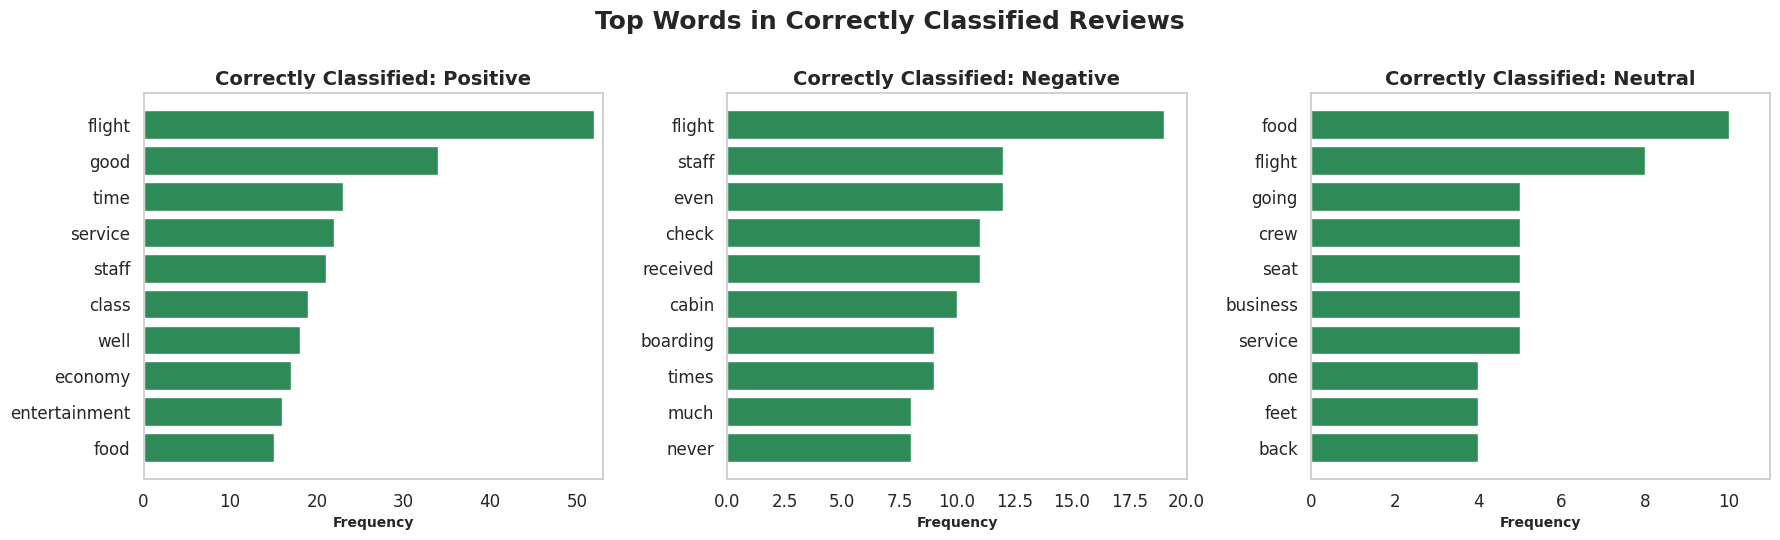

In [ ]:
# Filter out stopword-only phrases
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
    'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
    'should', 'now', 'would', 'told', 'go', 'got', 'get', 'singapore', 'airlines'
])

def is_meaningful(phrase):
    tokens = phrase.lower().split()
    return any(t not in stop_words for t in tokens)

filtered_phrases = {
    label: [p for p in phrases if is_meaningful(p)]
    for label, phrases in grouped_phrases.items()
}

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
axes = axes.flatten()

for ax, (label, phrases) in zip(axes, filtered_phrases.items()):
    phrase_counts = Counter(phrases)
    top_phrases = phrase_counts.most_common(10)
    if top_phrases:
        items, counts = zip(*top_phrases)
        ax.barh(items, counts, color='seagreen')
        ax.invert_yaxis()
        ax.set_xlim(0, max(counts) + 1)
    else:
        ax.text(0.5, 0.5, "No content phrases", ha='center', va='center')
    ax.set_title(f"Correctly Classified: {label}", fontsize=14, fontweight = "bold" )
    ax.set_xlabel("Frequency", fontsize=10, fontweight='bold')
    ax.grid(False)
plt.tight_layout()
plt.suptitle("Top Words in Correctly Classified Reviews\n\n\n", fontsize=18, y=1.08, fontweight = "bold")
plt.show()

In [ ]:
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
probs = clf.predict_proba(X_test_embeds)

df['pred_prob'] = probs.max(axis=1)
df['correct'] = df['sentiment_id'] == df['FT_distilbert_pred']
df['true_label_name'] = df['sentiment_id'].map(label_map)
df['pred_label_name'] = df['FT_distilbert_pred'].map(label_map)

# List of classes to extract
target_labels = ['Negative', 'Neutral', 'Positive']

correct_explanations = []
for label in target_labels:
    subset = df[
        (df['true_label_name'] == label) &
        (df['pred_label_name'] == label)
    ]
    subset = subset.sort_values(by='pred_prob', ascending=False)

    if subset.empty:
        print(f"No correctly classified examples found for {label}")
        continue

    # top 5 most confident correct predictions
    top5 = subset.head(5)

    for _, row in top5.iterrows():
        text_instance = row['text']
        idx = row.name

        print(f"\n Explaining correct prediction: {label} (index {idx})")

        explanation = explainer.explain_instance(
            text_instance,
            predict_proba,
            num_features=30
        )
        explanation.show_in_notebook(text=True)

        correct_explanations.append({
            'true': label,
            'pred': label,
            'index': idx,
            'explanation': explanation
        })